# Clasificación de imágenes con Deep Learning
- Miguel García López
- migue8gl@correo.ugr.es

## Introducción
- Se requiere clasificar imágenes de abejas y de hormigas de forma automática. Para ello se utilizará una red pre-entrenada y se hará uso de técnicas relacionadas con el *fine tuning* y el *transfer learning* para aprovechar ese conocimiento y aplicarlo a la clasificación de abejas y hormigas.
- El conjunto de datos utilizado es **hymenoptera**, el cual se ha extraído del siguiente tutorial de *pytorch*: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.
- El conjunto de datos cuenta con $120$ imágenes para el conjunto de entrenamiento y $75$ para el conjunto de evaluación.

## Selección de la red pre-entrenada
- Se procede a utilizar la red **ResNet-50** por las siguientes razones:
    - **Rendimiento probado**: **ResNet** es una de las arquitecturas más influyentes en visión por computador, con excelente desempeño en tareas de clasificación.
    - **Transfer learning efectivo**: **ResNet-50** pre-entrenada en *ImageNet* proporciona características robustas que se transfieren bien a otros dominios, incluso con conjuntos de datos pequeños como el de este laboratorio ($120$ imágenes por clase).
    - **Equilibrio complejidad-rendimiento**: Para un conjunto de datos relativamente pequeño como "hymenoptera_data", **ResNet-50** ofrece suficiente capacidad sin ser excesivamente compleja, evitando el sobreajuste y tiempos de computación muy elevados.

### Explicación de la red
- **ResNet** es una arquitectura de red neuronal presentada en este [paper](https://arxiv.org/pdf/1512.03385).
- Uno de los principales problemas en el *deep learning* es lo que se conoce como degradación. A medida que se profundizan las redes neuronales (más capas), uno esperaría que el rendimiento mejorase. Pero en la práctica ocurre lo contrario: las redes muy profundas tienden a entrenarse peor y muestran un mayor error de entrenamiento, no solo de validación. Este fenómeno se conoce como el problema del *"degradation"* y ocurre debido a la complejidad de minimizar la función de perdida cuando el número de capas aumenta.
- Los autores de **ResNet** propusieron una arquitectura que aprende las diferencias (residuos) entre la entrada y la salida esperada de una capa, en vez de aprender directamente la transformación completa. Este mapeo residual es más fácil de optimizar.
- **ResNet-50** es una versión de esta red con $50$ capas:

| Etapa (Stage) | Tipo de bloque | Número de bloques | Total de capas |
|---------------|----------------|-------------------|----------------|
| Conv1         | 7x7 conv       | 1                 | 1              |
| Conv2_x       | Bottleneck     | 3                 | 3 × 3 = 9       |
| Conv3_x       | Bottleneck     | 4                 | 4 × 3 = 12      |
| Conv4_x       | Bottleneck     | 6                 | 6 × 3 = 18      |
| Conv5_x       | Bottleneck     | 3                 | 3 × 3 = 9       |
| FC layer      | Fully connected| 1                 | 1              |
| **Total**     |                |                   | **50 capas**   |

- Cada bloque implementa estas transformaciones residuales.


# 1 - Full finetuning de toda la red con y sin transfer learning de ImageNet.

- Definimos las librerías a utilizar.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

- Cargamos el conjunto de datos y aplicamos transformaciones básicas para ajustar el tamaño de cada imágen. Usando `resize` hacemos que el lado más corto sea de $256$ píxeles para mantener la proporción. Luego se usa `center crop` para recortar la imagen y obtener una $224x224$, que es el que espera la red. De esta forma nos aseguramos el tamaño mínimo de la imagen sin causar distorsión y luego ajustamos al tamaño estándar de la red. Después se transforma a tensor.
- Se crean los objetos *dataloaders* para poder cragr los datos de manera eficiente en el entrenamiento.

In [2]:
# Definir rutas de datos
data_dir = "hymenoptera_data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# Definir transformaciones para las imágenes (sin data augmentation)
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    ),
}

# Cargar los datasets
image_datasets = {
    "train": datasets.ImageFolder(train_dir, data_transforms["train"]),
    "val": datasets.ImageFolder(val_dir, data_transforms["val"]),
}

dataloaders = {
    "train": torch.utils.data.DataLoader(
        image_datasets["train"], batch_size=4, shuffle=True, num_workers=4
    ),
    "val": torch.utils.data.DataLoader(
        image_datasets["val"], batch_size=4, shuffle=False, num_workers=4
    ),
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

- Definimos una función pata visualizar las imágenes con *seaborn*.

In [3]:
# Función para visualizar algunas imágenes usando seaborn
def imshow(inp, title=None):
    """Imshow para Tensor con seaborn."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 10))
    sns.heatmap(inp[:, :, 0], cmap="viridis")
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

- Se define una función de entrenamiento donde se define el modelo (**ResNet-50**), la función de pérdida, el algoritmo de optimización para minimizar la función de pérdida y el número de épocas a entrenar.
- Guardamos los mejores pesos, métricas y se almacena el histórico de las métricas para visualización.
- Cada época consta de dos fases: entrenamiento y validación
    - `model.train()`: Activa capas como *BatchNorm* y *Dropout* para el entrenamiento.
    - `model.eval()`: Desactiva estas capas para la evaluación/validación.

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_metrics = {"precision": 0, "recall": 0, "f1": 0}

    # Para graficar el progreso
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Cada época tiene una fase de entrenamiento y validación
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a cero los gradientes de los parámetros
                optimizer.zero_grad()

                # Forward
                # Realizar seguimiento del historial solo si estamos en fase de entrenamiento
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize solo si es fase de entrenamiento
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Recolectar predicciones y etiquetas para métricas
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Guardar métricas para gráficos
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())

            # Calcular métricas adicionales solo para validación
            if phase == "val":
                precision = precision_score(all_labels, all_preds, average="weighted")
                recall = recall_score(all_labels, all_preds, average="weighted")
                f1 = f1_score(all_labels, all_preds, average="weighted")
                print(
                    f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}"
                )
            else:
                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Guardar el mejor modelo
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_metrics = {"precision": precision, "recall": recall, "f1": f1}
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f"Entrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    print(f"Mejor precisión de val: {best_acc:.4f}")
    print(
        f"Mejores métricas - Precision: {best_metrics['precision']:.4f}, Recall: {best_metrics['recall']:.4f}, F1: {best_metrics['f1']:.4f}"
    )

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, num_epochs + 1), y=history["train_loss"], label="Train")
    sns.lineplot(x=range(1, num_epochs + 1), y=history["val_loss"], label="Validation")
    plt.title("Loss durante entrenamiento")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, num_epochs + 1), y=history["train_acc"], label="Train")
    sns.lineplot(x=range(1, num_epochs + 1), y=history["val_acc"], label="Validation")
    plt.title("Accuracy durante entrenamiento")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    return model, best_metrics

- Se realiza el entrenamiento usando los pesos aprendidos por la red tras el entrenamiento con el conjunto de datos *ImageNet* y se entrena sin esos pesos ya aprendidos para comparar el rendimiento de ambas redes. De esta forma se podrá analizar y discutir la importancia del uso de *transfer learning*.

Iniciando Full Finetuning con Transfer Learning (ImageNet)
Epoch 1/10
----------
train Loss: 0.4996 Acc: 0.7828
val Loss: 0.1694 Acc: 0.9477 Precision: 0.9502 Recall: 0.9477 F1: 0.9475

Epoch 2/10
----------
train Loss: 0.3470 Acc: 0.8607
val Loss: 0.1952 Acc: 0.9020 Precision: 0.9085 Recall: 0.9020 F1: 0.9021

Epoch 3/10
----------
train Loss: 0.2662 Acc: 0.8893
val Loss: 0.1968 Acc: 0.9608 Precision: 0.9619 Recall: 0.9608 F1: 0.9607

Epoch 4/10
----------
train Loss: 0.3888 Acc: 0.8770
val Loss: 0.2639 Acc: 0.9085 Precision: 0.9138 Recall: 0.9085 F1: 0.9087

Epoch 5/10
----------
train Loss: 0.2597 Acc: 0.9098
val Loss: 0.2011 Acc: 0.9542 Precision: 0.9548 Recall: 0.9542 F1: 0.9542

Epoch 6/10
----------
train Loss: 0.3281 Acc: 0.8852
val Loss: 0.5525 Acc: 0.8431 Precision: 0.8767 Recall: 0.8431 F1: 0.8418

Epoch 7/10
----------
train Loss: 0.2338 Acc: 0.9139
val Loss: 0.2567 Acc: 0.9281 Precision: 0.9283 Recall: 0.9281 F1: 0.9281

Epoch 8/10
----------
train Loss: 0.2441 Acc: 0.9221

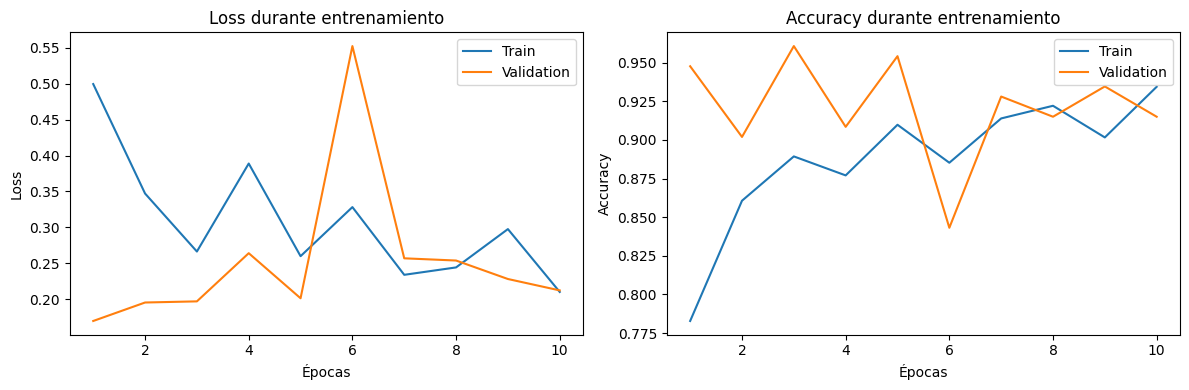


Resultados Full Finetuning con Transfer Learning:
Precision: 0.9619
Recall: 0.9608
F1 Score: 0.9607

Iniciando Full Finetuning sin Transfer Learning (desde cero)
Epoch 1/10
----------
train Loss: 5.8138 Acc: 0.5000
val Loss: 50.2220 Acc: 0.4183 Precision: 0.4249 Recall: 0.4183 F1: 0.4176

Epoch 2/10
----------
train Loss: 2.4465 Acc: 0.4672
val Loss: 1.5338 Acc: 0.4771 Precision: 0.4248 Recall: 0.4771 F1: 0.4179

Epoch 3/10
----------
train Loss: 1.3740 Acc: 0.4959
val Loss: 2.2712 Acc: 0.5425 Precision: 0.2943 Recall: 0.5425 F1: 0.3816

Epoch 4/10
----------


/home/migue8gl/Master/mineria_de_datos_aspectos_avanzados/p3/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train Loss: 1.4293 Acc: 0.5410
val Loss: 0.7145 Acc: 0.4902 Precision: 0.6812 Recall: 0.4902 F1: 0.3646

Epoch 5/10
----------
train Loss: 0.9003 Acc: 0.4754
val Loss: 1.1754 Acc: 0.5425 Precision: 0.2943 Recall: 0.5425 F1: 0.3816

Epoch 6/10
----------


/home/migue8gl/Master/mineria_de_datos_aspectos_avanzados/p3/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train Loss: 0.7419 Acc: 0.5246
val Loss: 0.7556 Acc: 0.4837 Precision: 0.6214 Recall: 0.4837 F1: 0.3609

Epoch 7/10
----------
train Loss: 0.7299 Acc: 0.5902
val Loss: 0.6680 Acc: 0.5752 Precision: 0.6088 Recall: 0.5752 F1: 0.5630

Epoch 8/10
----------
train Loss: 0.6671 Acc: 0.6270
val Loss: 0.8177 Acc: 0.5163 Precision: 0.5768 Recall: 0.5163 F1: 0.4671

Epoch 9/10
----------
train Loss: 0.6710 Acc: 0.6148
val Loss: 0.8611 Acc: 0.4575 Precision: 0.4798 Recall: 0.4575 F1: 0.3191

Epoch 10/10
----------
train Loss: 0.6904 Acc: 0.5738
val Loss: 0.8867 Acc: 0.5294 Precision: 0.5767 Recall: 0.5294 F1: 0.4974

Entrenamiento completado en 6m 19s
Mejor precisión de val: 0.5752
Mejores métricas - Precision: 0.6088, Recall: 0.5752, F1: 0.5630


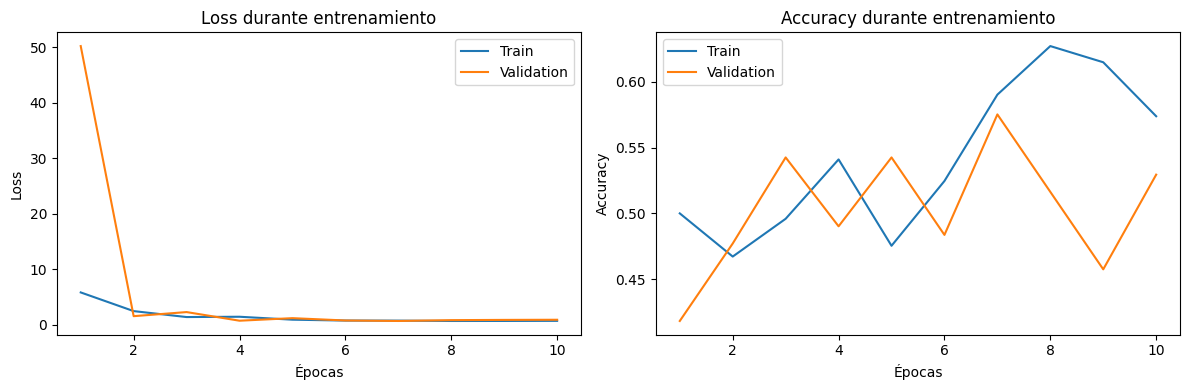


Resultados Full Finetuning sin Transfer Learning:
Precision: 0.6088
Recall: 0.5752
F1 Score: 0.5630

=== Tabla Comparativa de Resultados ===
                               Método  Precision   Recall  F1 Score
Full Finetuning con Transfer Learning   0.961891 0.960784  0.960669
Full Finetuning sin Transfer Learning   0.608752 0.575163  0.562977


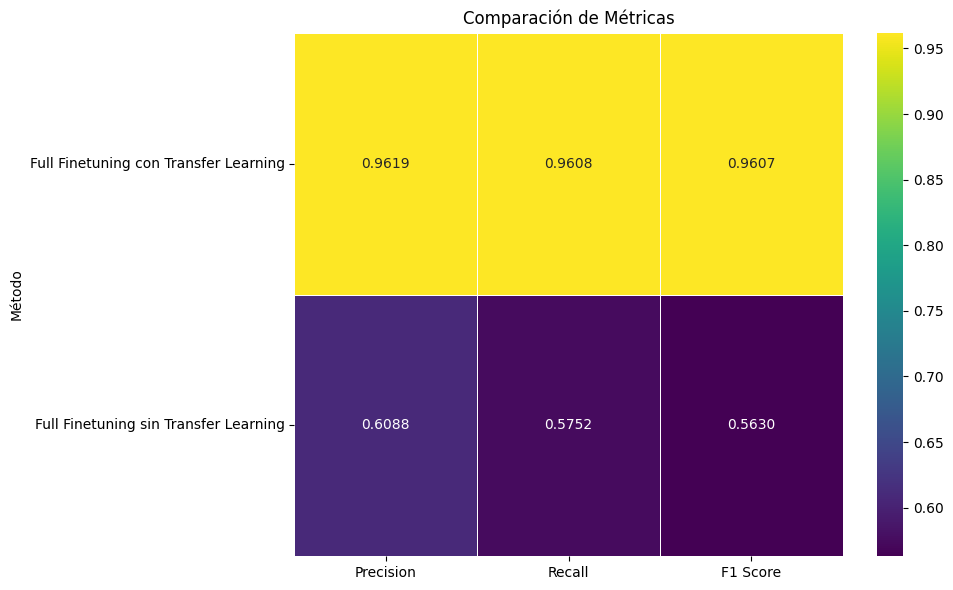

In [5]:
# =============== 1. Full Finetuning con Transfer Learning (ImageNet) ===============
print("Iniciando Full Finetuning con Transfer Learning (ImageNet)")

# Cargar modelo pre-entrenado
model_ft = models.resnet50(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features

# Modificar la última capa para nuestras clases
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Entrenar el modelo con transfer learning
model_ft, metrics_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10
)

print("\nResultados Full Finetuning con Transfer Learning:")
print(f"Precision: {metrics_ft['precision']:.4f}")
print(f"Recall: {metrics_ft['recall']:.4f}")
print(f"F1 Score: {metrics_ft['f1']:.4f}")

# =============== 2. Full Finetuning sin Transfer Learning (desde cero) ===============
print("\nIniciando Full Finetuning sin Transfer Learning (desde cero)")

# Cargar modelo sin pesos pre-entrenados
model_scratch = models.resnet50(weights=None)
num_ftrs = model_scratch.fc.in_features

# Modificar la última capa para nuestras clases
model_scratch.fc = nn.Linear(num_ftrs, len(class_names))
model_scratch = model_scratch.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler_scratch = lr_scheduler.StepLR(
    optimizer_scratch, step_size=7, gamma=0.1
)

# Entrenar el modelo desde cero
model_scratch, metrics_scratch = train_model(
    model_scratch, criterion, optimizer_scratch, exp_lr_scheduler_scratch, num_epochs=10
)

print("\nResultados Full Finetuning sin Transfer Learning:")
print(f"Precision: {metrics_scratch['precision']:.4f}")
print(f"Recall: {metrics_scratch['recall']:.4f}")
print(f"F1 Score: {metrics_scratch['f1']:.4f}")

results_data = {
    "Método": [
        "Full Finetuning con Transfer Learning",
        "Full Finetuning sin Transfer Learning",
    ],
    "Precision": [metrics_ft["precision"], metrics_scratch["precision"]],
    "Recall": [metrics_ft["recall"], metrics_scratch["recall"]],
    "F1 Score": [metrics_ft["f1"], metrics_scratch["f1"]],
}

results_df = pd.DataFrame(results_data)
print("\n=== Tabla Comparativa de Resultados ===")
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    results_df.set_index("Método")[["Precision", "Recall", "F1 Score"]],
    annot=True,
    cmap="viridis",
    fmt=".4f",
    linewidths=0.5,
)
plt.title("Comparación de Métricas")
plt.tight_layout()
plt.show()

## 1.1 - Análisis de resultados
- Como puede observarse, la red pre-entrenada es capaz de rendir mucho mejor que el modelo entrenado desde cero. Esto se debe a varios factores:
    - El *fine tuning* es una técnica que funciona. Al haber sido entrenada la red previamente en un conjunto de datos gigantesco, esta alberga gran cantidad de conocimiento sobre patrones encontrados en ese *dataset* que es mu generalizable. Al hacer un pequeño re-entreno con $10$ épocas, ya es capaz de usar parte de ese conocimiento.
    - La red sin conocimiento previo necesita muchísimas más imágenes para poder obtener valores de calidad, el *deep learning* es una técnica costosa en cuanto a datos.
- No se han utilizado más épocas ya que, en la gráfica de la función de pérdida, se puede observar como la mejora durante el tiempo es nimia. El algoritmo necesita más datos.

# 2 - Linear probing congelando el extractor de característica y entrenando sólo las últimas FC.

## 2.1 - Contexto
- El *Linear Probing* es una técnica comúnmente usada en aprendizaje profundo, especialmente en contextos de *transfer learning*. Se refiere a entrenar solo una capa lineal (*fully connected*) sobre una representación previamente extraída por un modelo pre-entrenado, congelando todas las capas anteriores (es decir, sin actualizarlas durante el entrenamiento).
- Rápido y computacionalmente menos costoso que entrenar toda la red.
- Si el modelo logra buen rendimiento solo con una capa lineal encima, es señal de que ha aprendido una representación potente.


Iniciando Linear Probing con Transfer Learning (ImageNet)
Número de parámetros a entrenar: 2
Epoch 1/10
----------
train Loss: 0.8667 Acc: 0.7418
val Loss: 0.9071 Acc: 0.8235 Precision: 0.8727 Recall: 0.8235 F1: 0.8207

Epoch 2/10
----------
train Loss: 1.9966 Acc: 0.7910
val Loss: 0.6478 Acc: 0.9085 Precision: 0.9217 Recall: 0.9085 F1: 0.9070

Epoch 3/10
----------
train Loss: 1.1812 Acc: 0.8402
val Loss: 1.1886 Acc: 0.8889 Precision: 0.9078 Recall: 0.8889 F1: 0.8864

Epoch 4/10
----------
train Loss: 1.9927 Acc: 0.7992
val Loss: 1.2596 Acc: 0.8497 Precision: 0.8806 Recall: 0.8497 F1: 0.8486

Epoch 5/10
----------
train Loss: 2.7883 Acc: 0.7705
val Loss: 2.9319 Acc: 0.7974 Precision: 0.8596 Recall: 0.7974 F1: 0.7925

Epoch 6/10
----------
train Loss: 6.6059 Acc: 0.7049
val Loss: 0.4973 Acc: 0.9412 Precision: 0.9434 Recall: 0.9412 F1: 0.9413

Epoch 7/10
----------
train Loss: 2.9485 Acc: 0.8156
val Loss: 0.9200 Acc: 0.9281 Precision: 0.9348 Recall: 0.9281 F1: 0.9282

Epoch 8/10
------

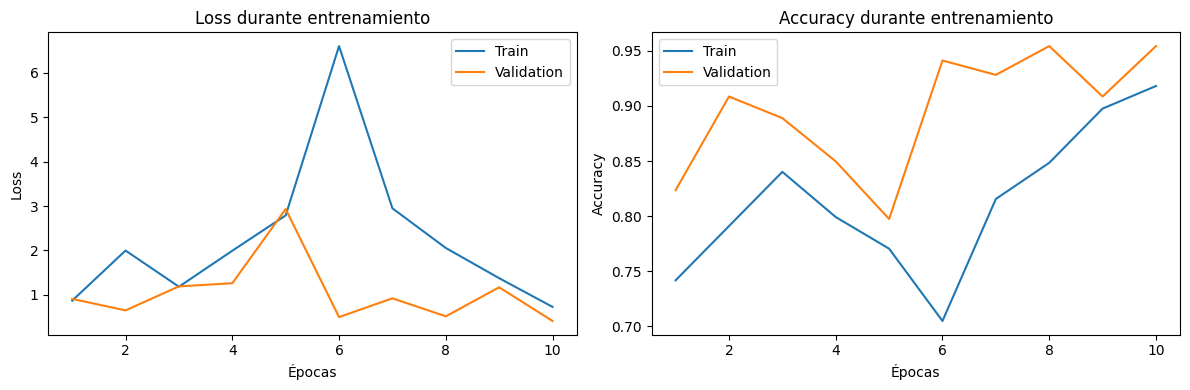


Resultados Linear Probing con Transfer Learning:
Precision: 0.9544
Recall: 0.9542
F1 Score: 0.9543

=== Tabla Comparativa de Resultados ===
                               Método  Precision   Recall  F1 Score
Full Finetuning con Transfer Learning   0.961891 0.960784  0.960669
Full Finetuning sin Transfer Learning   0.608752 0.575163  0.562977
 Linear Probing con Transfer Learning   0.954377 0.954248  0.954272


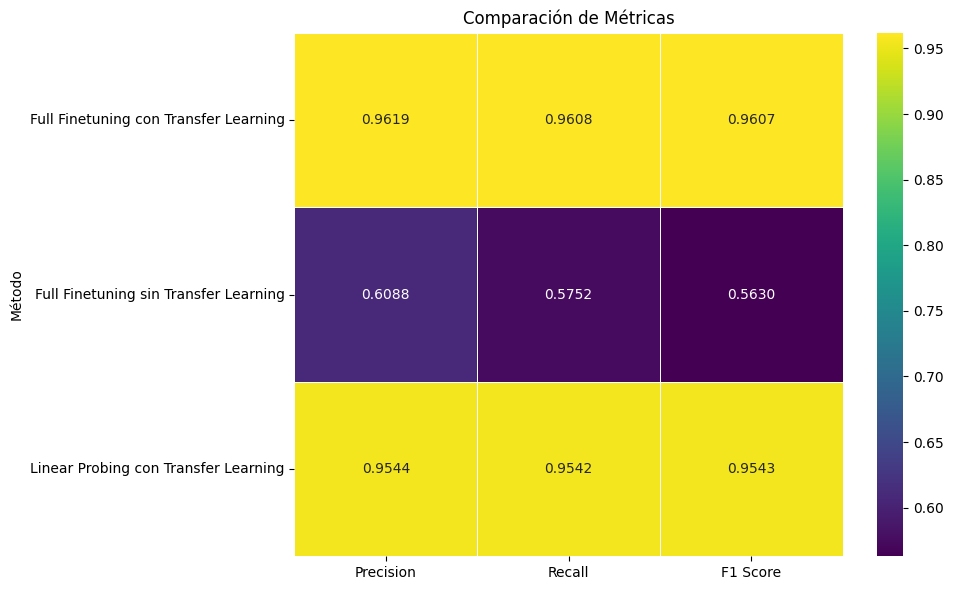

In [6]:
# =============== 3. Linear Probing con Transfer Learning ===============
print("\nIniciando Linear Probing con Transfer Learning (ImageNet)")

model_lp = models.resnet50(weights="IMAGENET1K_V1")
num_ftrs = model_lp.fc.in_features

model_lp.fc = nn.Linear(num_ftrs, len(class_names))
model_lp = model_lp.to(device)

# Congelar todos los parámetros excepto los de la última capa FC
for param in model_lp.parameters():
    param.requires_grad = False

# Habilitar gradientes solo para los parámetros de la última capa FC
for param in model_lp.fc.parameters():
    param.requires_grad = True

# Verificar qué parámetros se entrenarán
params_to_update = [param for param in model_lp.parameters() if param.requires_grad]
print(f"Número de parámetros a entrenar: {len(params_to_update)}")

# Solo optimizar los parámetros que tienen requires_grad=True
criterion = nn.CrossEntropyLoss()
optimizer_lp = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
exp_lr_scheduler_lp = lr_scheduler.StepLR(optimizer_lp, step_size=7, gamma=0.1)

# Entrenar solo la última capa (linear probing)
model_lp, metrics_lp = train_model(
    model_lp, criterion, optimizer_lp, exp_lr_scheduler_lp, num_epochs=10
)

print("\nResultados Linear Probing con Transfer Learning:")
print(f"Precision: {metrics_lp['precision']:.4f}")
print(f"Recall: {metrics_lp['recall']:.4f}")
print(f"F1 Score: {metrics_lp['f1']:.4f}")

results_data = {
    "Método": [
        "Full Finetuning con Transfer Learning",
        "Full Finetuning sin Transfer Learning",
        "Linear Probing con Transfer Learning",
    ],
    "Precision": [
        metrics_ft["precision"],
        metrics_scratch["precision"],
        metrics_lp["precision"],
    ],
    "Recall": [metrics_ft["recall"], metrics_scratch["recall"], metrics_lp["recall"]],
    "F1 Score": [metrics_ft["f1"], metrics_scratch["f1"], metrics_lp["f1"]],
}
results_df = pd.DataFrame(results_data)
print("\n=== Tabla Comparativa de Resultados ===")
print(results_df.to_string(index=False))

plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    results_df.set_index("Método")[["Precision", "Recall", "F1 Score"]],
    annot=True,
    cmap="viridis",
    fmt=".4f",
    linewidths=0.5,
)
plt.title("Comparación de Métricas")
plt.tight_layout()
plt.show()

## 2.2 - Análisis de resultados
- El uso de *linear probing* ha dado resultados mejorados con respecto a las dos técnicas utilizadas previamente. De hecho, no solo son mejores, sino que si nos fijamos en las gráficas, la tendencia tanto de la pérdida como de la métrica de referencia (*accuracy*) era a mejorar, por lo que se podría haber seguido entrenando.
- Estos resultados sugieren que las representaciones aprendidas por el modelo pre-entrenado son lo suficientemente ricas como para permitir una clasificación efectiva utilizando únicamente una capa lineal encima. Esto respalda la idea de que el *encoder* congelado ha capturado características relevantes y generalizables para la tarea actual, a pesar de no haber sido entrenado específicamente en este dominio.
- El *fine tuning*, aunque logró una mejora inicial rápida, posteriormente mostró una estabilización prematura o incluso degradación del rendimiento en el conjunto de validación.

# 3 - Linear probing más 3 transformaciones de data-augumentation

## 3.1 Contexto
- *Data augmentation* (aumento de datos) es una técnica que se utiliza en aprendizaje automático y especialmente en *deep learning* para aumentar artificialmente la cantidad y diversidad de los datos de entrenamiento sin tener que recolectar nuevos datos reales.
- Para imágenes, es muy común aplicar transformaciones como:
    - Rotaciones, escalado, recortes (*cropping*).
    - Giros horizontales/verticales.
    - Cambios de brillo, contraste, saturación.
    - Añadir ruido.
    - Desenfoque.
    - Transformaciones geométricas (*affine*, *perspective*).
- Son transformaciones recomendables sobre todo cuando se trabaja con pocos datos, como es el caso, ya que aumentan la cantidad de estos y aportan otros beneficios extra, como por ejemplo mayor robustez del modelo (ya que simula condiciones del mundo real), menor riesgo de sobreajuste y mayor generalización.


Iniciando Linear Probing con Transfer Learning + Data Augmentation
Número de parámetros a entrenar: 2
Epoch 1/10
----------
train Loss: 3.0009 Acc: 0.6066
val Loss: 1.3329 Acc: 0.8431 Precision: 0.8709 Recall: 0.8431 F1: 0.8422

Epoch 2/10
----------
train Loss: 2.9457 Acc: 0.7049
val Loss: 4.1170 Acc: 0.6405 Precision: 0.7811 Recall: 0.6405 F1: 0.6056

Epoch 3/10
----------
train Loss: 2.3399 Acc: 0.7459
val Loss: 0.7224 Acc: 0.9216 Precision: 0.9216 Recall: 0.9216 F1: 0.9216

Epoch 4/10
----------
train Loss: 2.4965 Acc: 0.8033
val Loss: 1.3666 Acc: 0.8889 Precision: 0.9018 Recall: 0.8889 F1: 0.8889

Epoch 5/10
----------
train Loss: 2.5682 Acc: 0.7459
val Loss: 0.8073 Acc: 0.9281 Precision: 0.9283 Recall: 0.9281 F1: 0.9281

Epoch 6/10
----------
train Loss: 3.5356 Acc: 0.7131
val Loss: 2.5552 Acc: 0.8170 Precision: 0.8552 Recall: 0.8170 F1: 0.8085

Epoch 7/10
----------
train Loss: 3.0771 Acc: 0.7582
val Loss: 1.0445 Acc: 0.9020 Precision: 0.9067 Recall: 0.9020 F1: 0.9011

Epoch 8/

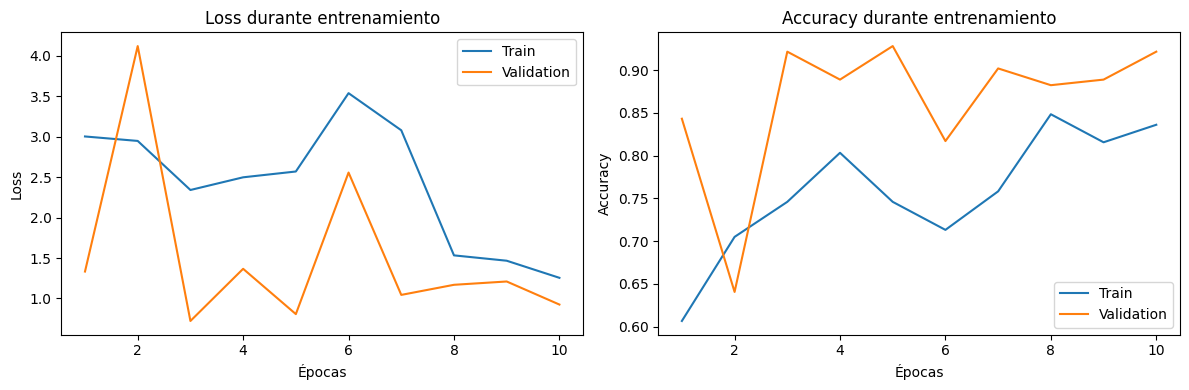


Resultados Linear Probing con Transfer Learning + Data Augmentation:
Precision: 0.9283
Recall: 0.9281
F1 Score: 0.9281

=== Tabla Comparativa de Resultados ===
                               Método  Precision   Recall  F1 Score
Full Finetuning con Transfer Learning   0.961891 0.960784  0.960669
Full Finetuning sin Transfer Learning   0.608752 0.575163  0.562977
 Linear Probing con Transfer Learning   0.954377 0.954248  0.954272
   Linear Probing + Data Augmentation   0.928258 0.928105  0.928142


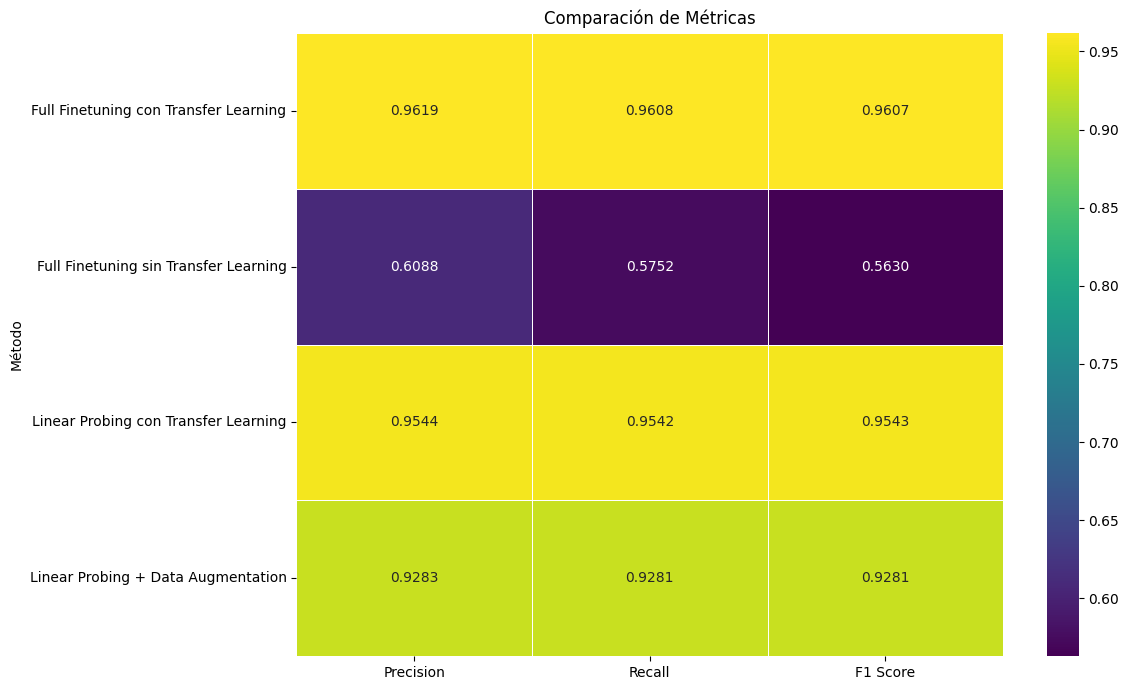

In [7]:
# =============== 4. Linear Probing con Transfer Learning + Data Augmentation ===============
print("\nIniciando Linear Probing con Transfer Learning + Data Augmentation")

# Definir transformaciones con data augmentation para entrenamiento
data_transforms_augmented = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),  # Rotación aleatoria de hasta 15 grados
            transforms.ColorJitter(
                brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1
            ),  # Ajustes de color
            transforms.ToTensor(),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    ),
}

# Cargar datasets con las nuevas transformaciones
image_datasets_augmented = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms_augmented[x])
    for x in ["train", "val"]
}
dataloaders_augmented = {
    x: torch.utils.data.DataLoader(
        image_datasets_augmented[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes_augmented = {
    x: len(image_datasets_augmented[x]) for x in ["train", "val"]
}

# Guardar los dataloaders originales
dataloaders_original = dataloaders
dataset_sizes_original = dataset_sizes

# Reemplazar con los dataloaders aumentados
dataloaders = dataloaders_augmented
dataset_sizes = dataset_sizes_augmented

model_lp_aug = models.resnet50(weights="IMAGENET1K_V1")
num_ftrs = model_lp_aug.fc.in_features

model_lp_aug.fc = nn.Linear(num_ftrs, len(class_names))
model_lp_aug = model_lp_aug.to(device)

# Congelar todos los parámetros excepto los de la última capa FC
for param in model_lp_aug.parameters():
    param.requires_grad = False

# Habilitar gradientes solo para los parámetros de la última capa FC
for param in model_lp_aug.fc.parameters():
    param.requires_grad = True

# Verificar qué parámetros se entrenarán
params_to_update = [param for param in model_lp_aug.parameters() if param.requires_grad]
print(f"Número de parámetros a entrenar: {len(params_to_update)}")

# Solo optimizar los parámetros que tienen requires_grad=True
criterion = nn.CrossEntropyLoss()
optimizer_lp_aug = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
exp_lr_scheduler_lp_aug = lr_scheduler.StepLR(optimizer_lp_aug, step_size=7, gamma=0.1)

# Entrenar solo la última capa (linear probing) con data augmentation
model_lp_aug, metrics_lp_aug = train_model(
    model_lp_aug, criterion, optimizer_lp_aug, exp_lr_scheduler_lp_aug, num_epochs=10
)

# Restaurar los dataloaders originales
dataloaders = dataloaders_original
dataset_sizes = dataset_sizes_original

print("\nResultados Linear Probing con Transfer Learning + Data Augmentation:")
print(f"Precision: {metrics_lp_aug['precision']:.4f}")
print(f"Recall: {metrics_lp_aug['recall']:.4f}")
print(f"F1 Score: {metrics_lp_aug['f1']:.4f}")

results_data = {
    "Método": [
        "Full Finetuning con Transfer Learning",
        "Full Finetuning sin Transfer Learning",
        "Linear Probing con Transfer Learning",
        "Linear Probing + Data Augmentation",
    ],
    "Precision": [
        metrics_ft["precision"],
        metrics_scratch["precision"],
        metrics_lp["precision"],
        metrics_lp_aug["precision"],
    ],
    "Recall": [
        metrics_ft["recall"],
        metrics_scratch["recall"],
        metrics_lp["recall"],
        metrics_lp_aug["recall"],
    ],
    "F1 Score": [
        metrics_ft["f1"],
        metrics_scratch["f1"],
        metrics_lp["f1"],
        metrics_lp_aug["f1"],
    ],
}
results_df = pd.DataFrame(results_data)
print("\n=== Tabla Comparativa de Resultados ===")
print(results_df.to_string(index=False))

# Visualizar la comparación actualizada
plt.figure(figsize=(12, 7))
ax = sns.heatmap(
    results_df.set_index("Método")[["Precision", "Recall", "F1 Score"]],
    annot=True,
    cmap="viridis",
    fmt=".4f",
    linewidths=0.5,
)
plt.title("Comparación de Métricas")
plt.tight_layout()
plt.show()

# 4 - Entrenando el modelo durante 5 epocas usando linear probing y 3 epocas usando Finetuning


Iniciando Linear Probing (5 épocas) seguido de Finetuning (3 épocas)
Fase 1: Linear Probing (5 épocas)
Epoch 1/5
----------
train Loss: 0.8114 Acc: 0.7746
val Loss: 0.2580 Acc: 0.9216 Precision: 0.9282 Recall: 0.9216 F1: 0.9208

Epoch 2/5
----------
train Loss: 1.9425 Acc: 0.7623
val Loss: 0.8576 Acc: 0.8824 Precision: 0.8971 Recall: 0.8824 F1: 0.8823

Epoch 3/5
----------
train Loss: 2.4025 Acc: 0.7992
val Loss: 1.6061 Acc: 0.8562 Precision: 0.8846 Recall: 0.8562 F1: 0.8553

Epoch 4/5
----------
train Loss: 4.4987 Acc: 0.7172
val Loss: 0.6731 Acc: 0.9346 Precision: 0.9377 Recall: 0.9346 F1: 0.9348

Epoch 5/5
----------
train Loss: 2.2862 Acc: 0.7869
val Loss: 0.5674 Acc: 0.9477 Precision: 0.9487 Recall: 0.9477 F1: 0.9476

Entrenamiento completado en 0m 17s
Mejor precisión de val: 0.9477
Mejores métricas - Precision: 0.9487, Recall: 0.9477, F1: 0.9476


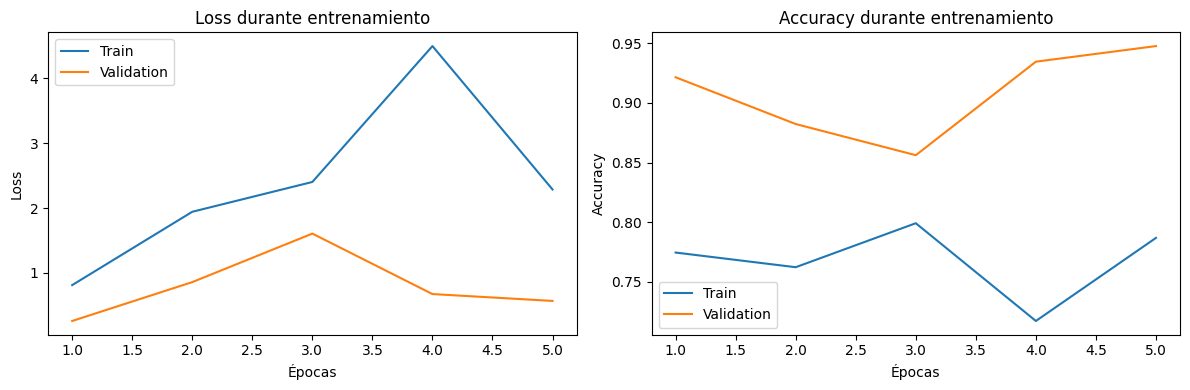

Fase 2: Finetuning completo (3 épocas)
Epoch 1/3
----------
train Loss: 6.9589 Acc: 0.5164
val Loss: 6.3471 Acc: 0.5294 Precision: 0.5316 Recall: 0.5294 F1: 0.5301

Epoch 2/3
----------
train Loss: 1.6796 Acc: 0.5533
val Loss: 4.9210 Acc: 0.6144 Precision: 0.6300 Recall: 0.6144 F1: 0.6125

Epoch 3/3
----------
train Loss: 0.8413 Acc: 0.5615
val Loss: 1.8450 Acc: 0.5882 Precision: 0.5852 Recall: 0.5882 F1: 0.5728

Entrenamiento completado en 0m 21s
Mejor precisión de val: 0.6144
Mejores métricas - Precision: 0.6300, Recall: 0.6144, F1: 0.6125


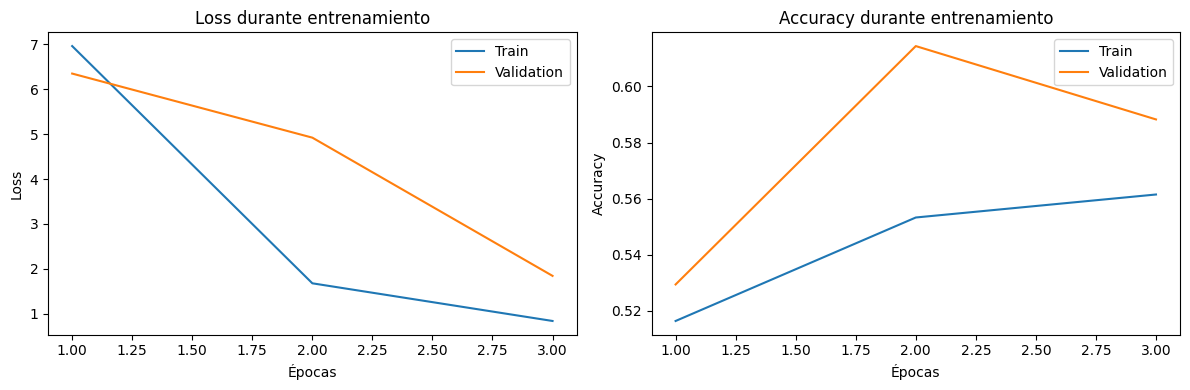


Resultados Linear Probing (5 épocas) + Finetuning (3 épocas):
Precision: 0.6300
Recall: 0.6144
F1 Score: 0.6125

=== Tabla Comparativa de Resultados ===
                               Método  Precision   Recall  F1 Score
Full Finetuning con Transfer Learning   0.961891 0.960784  0.960669
Full Finetuning sin Transfer Learning   0.608752 0.575163  0.562977
 Linear Probing con Transfer Learning   0.954377 0.954248  0.954272
   Linear Probing + Data Augmentation   0.928258 0.928105  0.928142
  Linear Probing (5) + Finetuning (3)   0.629989 0.614379  0.612498


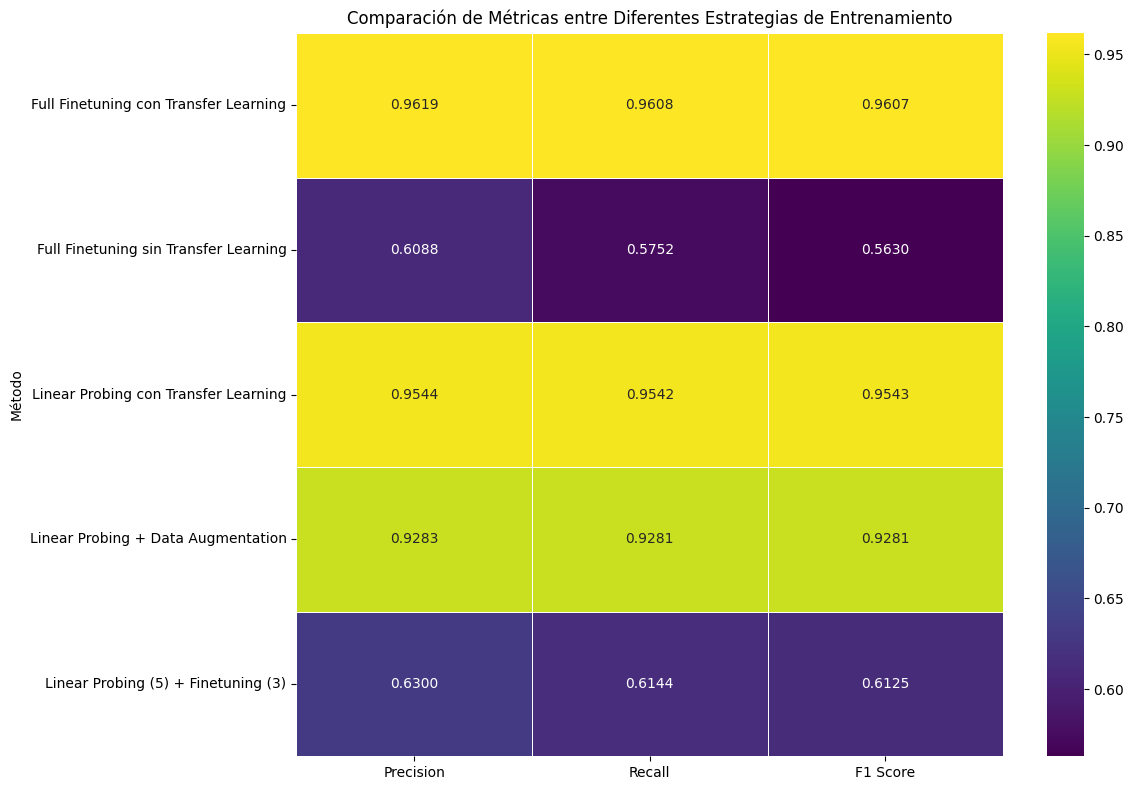

In [10]:
# =============== 5. Linear Probing (5 épocas) + Finetuning (3 épocas) ===============
print("\nIniciando Linear Probing (5 épocas) seguido de Finetuning (3 épocas)")

model_combined = models.resnet50(weights="IMAGENET1K_V1")
num_ftrs = model_combined.fc.in_features

model_combined.fc = nn.Linear(num_ftrs, len(class_names))
model_combined = model_combined.to(device)

# Paso 1: Linear Probing (5 épocas)
print("Fase 1: Linear Probing (5 épocas)")

# Congelar todos los parámetros excepto los de la última capa FC
for param in model_combined.parameters():
    param.requires_grad = False

# Habilitar gradientes solo para los parámetros de la última capa FC
for param in model_combined.fc.parameters():
    param.requires_grad = True

# Solo optimizar los parámetros que tienen requires_grad=True
criterion = nn.CrossEntropyLoss()
optimizer_lp_phase = optim.SGD(
    [param for param in model_combined.parameters() if param.requires_grad],
    lr=0.01,
    momentum=0.9,
)
exp_lr_scheduler_lp_phase = lr_scheduler.StepLR(
    optimizer_lp_phase, step_size=7, gamma=0.1
)

# Entrenar solo la última capa (linear probing) por 5 épocas
model_combined, _ = train_model(
    model_combined,
    criterion,
    optimizer_lp_phase,
    exp_lr_scheduler_lp_phase,
    num_epochs=5,
)

# Paso 2: Finetuning (3 épocas)
print("Fase 2: Finetuning completo (3 épocas)")

# Descongelar todos los parámetros para el finetuning
for param in model_combined.parameters():
    param.requires_grad = True

optimizer_ft_phase = optim.SGD(model_combined.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler_ft_phase = lr_scheduler.StepLR(
    optimizer_ft_phase, step_size=7, gamma=0.1
)

# Realizar finetuning del modelo completo por 3 épocas adicionales
model_combined, metrics_combined = train_model(
    model_combined,
    criterion,
    optimizer_ft_phase,
    exp_lr_scheduler_ft_phase,
    num_epochs=3,
)

print("\nResultados Linear Probing (5 épocas) + Finetuning (3 épocas):")
print(f"Precision: {metrics_combined['precision']:.4f}")
print(f"Recall: {metrics_combined['recall']:.4f}")
print(f"F1 Score: {metrics_combined['f1']:.4f}")

results_data = {
    "Método": [
        "Full Finetuning con Transfer Learning",
        "Full Finetuning sin Transfer Learning",
        "Linear Probing con Transfer Learning",
        "Linear Probing + Data Augmentation",
        "Linear Probing (5) + Finetuning (3)",
    ],
    "Precision": [
        metrics_ft["precision"],
        metrics_scratch["precision"],
        metrics_lp["precision"],
        metrics_lp_aug["precision"],
        metrics_combined["precision"],
    ],
    "Recall": [
        metrics_ft["recall"],
        metrics_scratch["recall"],
        metrics_lp["recall"],
        metrics_lp_aug["recall"],
        metrics_combined["recall"],
    ],
    "F1 Score": [
        metrics_ft["f1"],
        metrics_scratch["f1"],
        metrics_lp["f1"],
        metrics_lp_aug["f1"],
        metrics_combined["f1"],
    ],
}
results_df = pd.DataFrame(results_data)
print("\n=== Tabla Comparativa de Resultados ===")
print(results_df.to_string(index=False))

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    results_df.set_index("Método")[["Precision", "Recall", "F1 Score"]],
    annot=True,
    cmap="viridis",
    fmt=".4f",
    linewidths=0.5,
)
plt.title("Comparación de Métricas entre Diferentes Estrategias de Entrenamiento")
plt.tight_layout()
plt.show()

# 5 - Resultados
- El *transfer learning* es esencial: Tanto en *linear probing* como en *finetuning* completo, mejora claramente los resultados respecto a entrenar desde cero. Esto se debe, como se comentaba anteriormente, a que no hay suficientes datos, por lo que aprovechar conocimiento previo es esencial.
- *Data Augmentation* potencia el modelo sin necesidad de modificar la estructura del modelo. Muy útil en *datasets* pequeños como este.
- *linear probing* + *transfer learning* han resultado ser la mejor combinación para el entreno de la red. 
- La peor opción ha sido *linear probing* + *fine tuning*. Hay que tener en cuenta que es un conjunto de datos sencillo y quizás un *finetuning* final de solo $3$ épocas sea insuficiente, de hecho al principio con solo *linear probing* va obteniendo muy buenas métricas.